In [12]:
import numpy as np
import sympy as sp

from qiskit import QuantumCircuit, transpile
from qiskit_aer import StatevectorSimulator, UnitarySimulator

from typing import Dict, List, Tuple, Union, Optional
import warnings


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import scipy
import cmath

from diff_op import LaplacianOperator, DifferentialOperator, Operator, IdentityOperator
from svp_op import binary_coord, qma_grouping, bit2op
from lchsimulation import LCHSimulation

In this note, we will set the identity $I$ and

the Ladder Operators
$$
R = \sigma_{01}:=\left[\begin{array}{ll}
0 & 1 \\
0 & 0
\end{array}\right], \quad L = \sigma_{10}:=\left[\begin{array}{ll}
0 & 0 \\
1 & 0
\end{array}\right],
$$

the Projector Operators
$$
U = \sigma_{00}:=\left[\begin{array}{ll}
1 & 0 \\
0 & 0
\end{array}\right], \quad D = \sigma_{11}:=\left[\begin{array}{ll}
0 & 0 \\
0 & 1
\end{array}\right] .
$$

When we write in a dictionary 'IRLDU': 2.0, it means the following tensor product:

$$
2.0\; I \otimes R \otimes L \otimes D \otimes U
$$


Before we turn to the operator, let us first see how to use spatial varying parameter operators.

In [2]:
# example coordinates
coords = [(1, 2), (1, 3), (3, 2), (3, 3), (0, 2)]

# convert the coordinates to binary strings
minterms = binary_coord(coords, digits=2)
print(minterms)

# group the binary strings
c_dict = qma_grouping(minterms)
print(c_dict)

# convert the binary strings to a dictionary of matrices
c_dict = bit2op(c_dict, embed_bits=[2, 2])
print(c_dict)


['1001', '1101', '1011', '1111', '1000']
{'1--1': 1.0, '100-': 1.0}
{'DIID': 1.0, 'DUUU': 1.0}


Now, let us reproduce the pattern in the research with directly the simplified dictionary

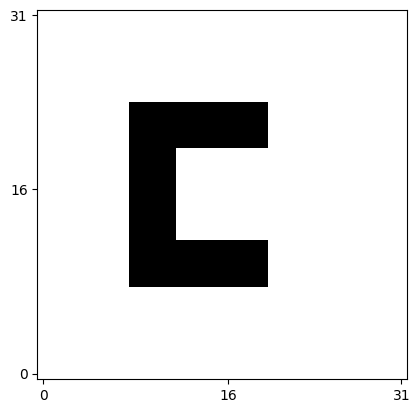

In [3]:
c_dict = {
    "010-100-": 1,
    "101-100-": 1,
    "010-01--": 1,
    "101-01--": 1,
    "10--010-": 1,
    "01--010-": 1
}

nx = 5
ny = 5
c1 = 10.0

# Here there are only 8 bits, the embed_bits is set to [5, 5] to make the total number of bits 10
c_dict = bit2op(c_dict, embed_bits=[nx, ny])

# Construct the operator where the addition is defined
c_op = Operator(num_bits=nx+ny, op_dict=c_dict)
I_op = IdentityOperator(num_qubits=nx+ny)

# This is the final operator used in the paper
op = (c1-1.0) * c_op + 1.0 * I_op

# Plot the diagonal elements of the operator
x, y = np.meshgrid(np.arange(2**nx), np.arange(2**ny))
matrix = np.diag(op.op2matrix().real).reshape((2**ny, 2**nx))

fig, ax = plt.subplots(1, 1)
ax.imshow(matrix, cmap='gray_r', origin='lower')
ax.set_aspect('equal')
ax.set_xticks(list(range(0, 2**nx, 16)) + [2**nx - 1])
ax.set_yticks(list(range(0, 2**ny, 16)) + [2**ny - 1])

plt.show()

### Acoustic Wave Equation

The definition of the Hamiltonian

In [22]:
def acoustic_wave_hamiltonian(nx, ny, h, bc_dict, c_dict, c1):

    op_c_dict = bit2op(c_dict, embed_bits=[nx, ny])

    c1_op = Operator(num_bits=nx+ny, op_dict=op_c_dict)
    I_op = IdentityOperator(num_qubits=nx+ny)
    c_op = (c1-1.0) * c1_op + 1.0 * I_op

    U_op = Operator(num_bits=1, op_dict={'U': 1})
    R_op = Operator(num_bits=1, op_dict={'R': 1})
    L_op = Operator(num_bits=1, op_dict={'L': 1})

    UR_op = U_op.tensor_product(R_op)
    RU_op = R_op.tensor_product(U_op)
    UL_op = U_op.tensor_product(L_op)
    LU_op = L_op.tensor_product(U_op)

    cDpx = c_op @ DifferentialOperator(num_bits_x=nx, num_bits_y=ny, direction='forward', dim=2, axis='0', h=h, bc=bc_dict)
    cDpy = c_op @ DifferentialOperator(num_bits_x=nx, num_bits_y=ny, direction='forward', dim=2, axis='1', h=h, bc=bc_dict)

    cDmx = DifferentialOperator(num_bits_x=nx, num_bits_y=ny, direction='backward', dim=2, axis='0', h=h, bc=bc_dict) @ c_op
    cDmy = DifferentialOperator(num_bits_x=nx, num_bits_y=ny, direction='backward', dim=2, axis='1', h=h, bc=bc_dict) @ c_op

    H = 1j * (UR_op.tensor_product(cDpx) + RU_op.tensor_product(cDpy) + UL_op.tensor_product(cDmx) + LU_op.tensor_product(cDmy))

    return H

Here we gave the simulation procedure with matrix exponential matrix and LCHS.

The following three blocks should be implemented in order.

In [23]:
nx = 5
ny = 5
c1 = 10
h = 1.0

bc_dict = {
    '0': ('D', 'D'),
    '1': ('P', 'P')
}

c_dict = {
    "010-100-": 1,
    "101-100-": 1,
    "010-01--": 1,
    "101-01--": 1,
    "10--010-": 1,
    "01--010-": 1
}

H = acoustic_wave_hamiltonian(nx, ny, h, bc_dict, c_dict, c1)
lchs = LCHSimulation(op=H)

In [24]:
# Simulation with LCHS
# Simulation parameters
T = 20.0
dt = 0.001
dt_sample = 0.01
sample_rate = 10

# Circuit
circuit = lchs.simulation_circuit(dt=dt)

# Initial state
w_q = np.zeros((2, 2, 2**nx, 2**ny), dtype=np.complex128)
w_q[0, 0, 2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
w_q = w_q.flatten()
w_q = w_q / np.sqrt(np.sum(w_q))

# Simulation
w_q_list = lchs.matrix_simulation_evolve(T=T, state=w_q, sample_rate=sample_rate)

In [26]:
# Initial state in matrix form
w_c = np.zeros((2, 2, 2**nx, 2**ny), dtype=np.complex128)
w_c[0, 0, 2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
w_c = w_c.flatten()
w_c = w_c / np.sqrt(np.sum(w_c))

w_c_list = []

# Matrix Hamiltonian
H_mat = H.op2matrix()
U = scipy.linalg.expm(-1j*H_mat*dt)

for i in range(int(T/dt)):

    if i % int(dt_sample/dt) == 0:
        w_c_list.append(w_c)
    
    w_c = U @ w_c

w_c_list.append(w_c)
w_c_list = np.array(w_c_list)

Let us show the simulation results in figures

First one is the LCHS method

[np.float64(0.35355339059327373), np.float64(0.11718666632389006), np.float64(0.08471363242739073)]


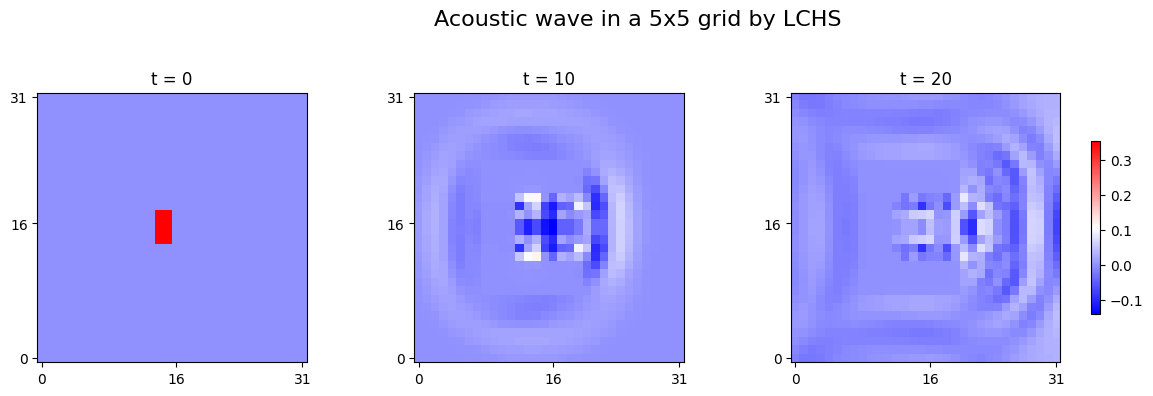

In [25]:
idx = [0, 10, 20]
n, nx, ny, dt = 12, 5, 5, 0.01

# make a copy of the data
w = w_q_list.copy()

# 1) build all 2D snapshots in order
zs = [
    w[int(t/dt), :2**(n-2)].real.reshape(2**ny, 2**nx)
    for t in idx
]

# 2) find global min/max
vmin = min(z.min() for z in zs)
vmax = max(z.max() for z in zs)

# 3) prep norm + colormap
cmap = 'bwr'
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 4) make subplots
fig, axes = plt.subplots(1, len(idx), figsize=(16, 4.5))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# 5) plot each panel in sequence
for ax, z, t in zip(axes, zs, idx):
    im = ax.imshow(z, origin='lower', cmap=cmap, norm=norm)
    ax.set_aspect('equal')
    ax.set_xticks(list(range(0, 2**nx, 16)) + [2**nx-1])
    ax.set_yticks(list(range(0, 2**ny, 16)) + [2**ny-1])
    ax.set_title(f't = {t}')

# optional: print the maxima
print([z.max() for z in zs])

# 6) add the colorbar (pad bumped to avoid overlap)
fig.colorbar(im, ax=axes, pad=0.025, shrink=0.5)

# 7) super‐title + spacing just like before
fig.suptitle('Acoustic wave in a 5x5 grid by LCHS',
             fontsize=16)

plt.show()

Next is the matrix exponential method

[np.float64(0.35355339059327373), np.float64(0.11586758417094406), np.float64(0.08343712924236742)]


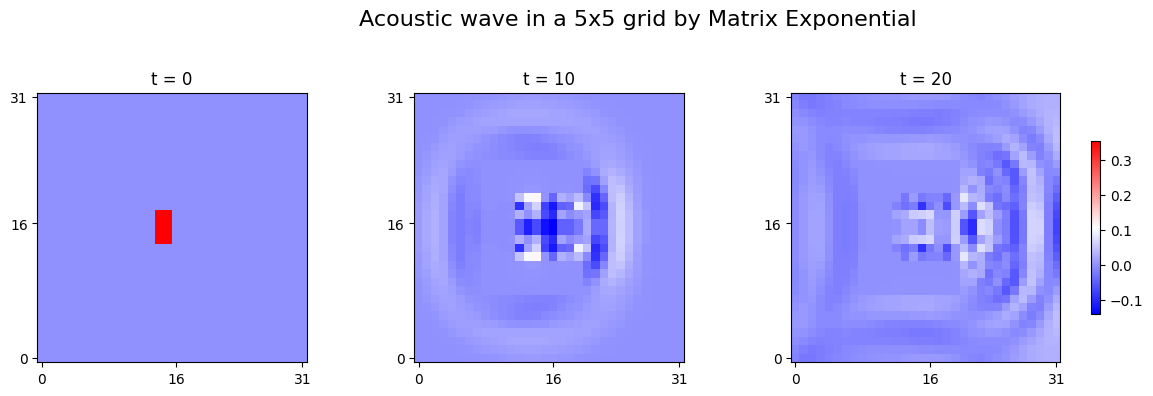

In [27]:
idx = [0, 10, 20]
n, nx, ny, dt = 12, 5, 5, 0.01

# make a copy of the data
w = w_c_list.copy()

# 1) build all 2D snapshots in order
zs = [
    w[int(t/dt), :2**(n-2)].real.reshape(2**ny, 2**nx)
    for t in idx
]

# 2) find global min/max
vmin = min(z.min() for z in zs)
vmax = max(z.max() for z in zs)

# 3) prep norm + colormap
cmap = 'bwr'
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 4) make subplots
fig, axes = plt.subplots(1, len(idx), figsize=(16, 4.5))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# 5) plot each panel in sequence
for ax, z, t in zip(axes, zs, idx):
    im = ax.imshow(z, origin='lower', cmap=cmap, norm=norm)
    ax.set_aspect('equal')
    ax.set_xticks(list(range(0, 2**nx, 16)) + [2**nx-1])
    ax.set_yticks(list(range(0, 2**ny, 16)) + [2**ny-1])
    ax.set_title(f't = {t}')

# optional: print the maxima
print([z.max() for z in zs])

# 6) add the colorbar (pad bumped to avoid overlap)
fig.colorbar(im, ax=axes, pad=0.025, shrink=0.5)

# 7) super‐title + spacing just like before
fig.suptitle('Acoustic wave in a 5x5 grid by Matrix Exponential',
             fontsize=16)

plt.show()


### Heat Equation

Since we have not shown the Heat equation in the presentation, we will list some basic information for the numerical simualtion. First, the 2d Heat equation is given by

$$
\frac{\partial \theta(t, \boldsymbol{x})}{\partial t}=\kappa \nabla^2 \theta(t, \boldsymbol{x}), \text { for }(t, \boldsymbol{x}) \in(0, T] \times \Omega,
$$

The Hamiltonian can be decomposed into two parts

$$
\begin{aligned}
\boldsymbol{H} & =\frac{\boldsymbol{A}-\boldsymbol{A}^{\dagger}}{2 i}=0 \\
\boldsymbol{L} & =\frac{\boldsymbol{A}+\boldsymbol{A}^{\dagger}}{2}=-\frac{\kappa}{2} \sum_{\mu=0}^{d-1}\left(D_\mu^{+} D_\mu^{-}+D_\mu^{-} D_\mu^{+}\right)
\end{aligned}
$$

Here $n_0=n_1=4, \tau=1.0\times 10^-1, T=10, h=1, \kappa=0.1$. The initial condition is given by

$$
\boldsymbol{w}(0)=|w(0)\rangle=\frac{\sqrt{2}}{4}(|0110\rangle+|0111\rangle+|1000\rangle+|1001\rangle) \otimes(|0110\rangle+|0111\rangle)
$$

corresponding to

$$
\theta\left(0, \boldsymbol{x}^{[j]}\right)= \begin{cases}\frac{\sqrt{2}}{4} & \text { for } x_1^{[j]} \in\{6,7,8,9\}, x_0^{[j]} \in\{6,7\} \\ 0 & \text { otherwise. }\end{cases}
$$

It can be generated using the following state preparation oracle

$$
O_{\text {prep }}=\underbrace{\mathrm{CX}_{8,7} \mathrm{CX}_{8,6}\left(H \otimes X^{\otimes 2} \otimes H\right)}_{\text {State preparation for } x_1^{[j]}} \otimes \underbrace{I \otimes X^{\otimes 2} \otimes H}_{\text {State preparation for } x_0^{[j]}} .
$$

Impose the Dirichlet boundary conditions for all boundaries.

Define the Hamiltionian

In [81]:
def heat_hamiltonian(nx, ny, h, bc_dict, kappa):

    Dpx = DifferentialOperator(num_bits_x=nx, num_bits_y=ny, direction='forward', dim=2, axis='0', h=h, bc=bc_dict)
    Dpy = DifferentialOperator(num_bits_x=nx, num_bits_y=ny, direction='forward', dim=2, axis='1', h=h, bc=bc_dict)

    Dmx = DifferentialOperator(num_bits_x=nx, num_bits_y=ny, direction='backward', dim=2, axis='0', h=h, bc=bc_dict)
    Dmy = DifferentialOperator(num_bits_x=nx, num_bits_y=ny, direction='backward', dim=2, axis='1', h=h, bc=bc_dict)

    Lx = LaplacianOperator(num_bits_x=nx, num_bits_y=ny, dim=2, axis='0', h=h, bc=bc_dict)
    Ly = LaplacianOperator(num_bits_x=nx, num_bits_y=ny, dim=2, axis='1', h=h, bc=bc_dict)

    #L = (1j)* kappa/2 * (Dpx @ Dmx + Dmx @ Dpx + Dpy @ Dmy + Dmy @ Dpy)
    L =  -kappa/2 * (Dpx @ Dmx + Dmx @ Dpx + Dpy @ Dmy + Dmy @ Dpy)
    #L = -kappa * (Lx + Ly)

    return L

In [82]:
nx = 4
ny = 4
h = 1.0
kappa = 0.1

# State preparation circuit
prep_circ = QuantumCircuit(nx + ny)
prep_circ.h(prep_circ.qubits[ny + nx - 1]) # most significant bit for y
prep_circ.h(prep_circ.qubits[nx])
for i in range(1, ny-1):
    prep_circ.cx(prep_circ.qubits[ny + nx - 1], prep_circ.qubits[nx + i])
    prep_circ.x(prep_circ.qubits[nx + i])

prep_circ.h(prep_circ.qubits[0]) # least significant bit for x
for i in range(1, nx-1):
    prep_circ.x(prep_circ.qubits[i])

# Initial state in matrix form
w_c = np.zeros((2**nx, 2**ny))
w_c[2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
w_c = w_c.flatten()
w_c = w_c / np.linalg.norm(w_c)

Exponential Matrix Simulation

In [83]:
# Simulation parameters
T = 10.0
dt = 0.1

# boundary conditions
bc_dict = {
    '0': ('D', 'D'),
    '1': ('D', 'D')
}

L = heat_hamiltonian(nx, ny, h, bc_dict, kappa)
L_mat = L.op2matrix()
U = scipy.linalg.expm(-L_mat*dt)

w_c_list = []
for i in range(int(T/dt)):
    w_c = U @ w_c
    w_c_list.append(w_c)

w_c_list.append(w_c)
w_c_list = np.array(w_c_list)

[np.float64(0.3500356481432472), np.float64(0.2200349380083447), np.float64(0.15412549795952676)]


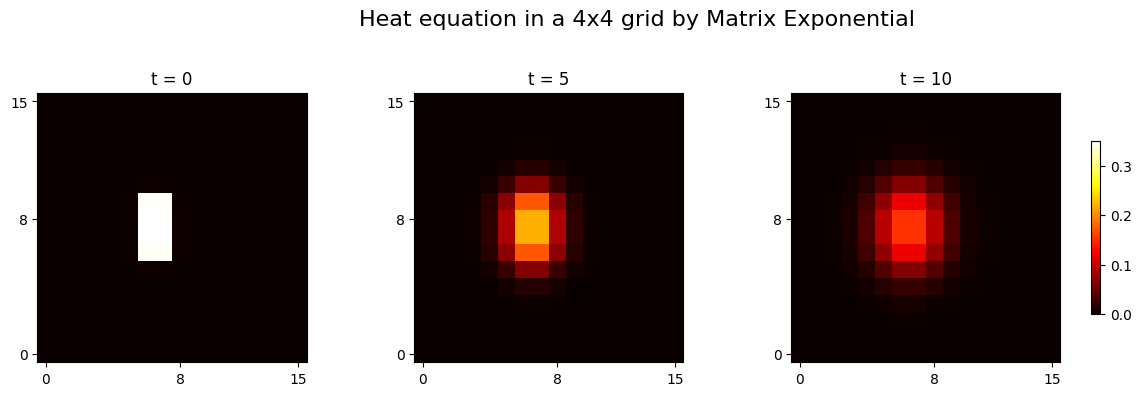

In [84]:
idx = [0, 5, 10]
n, nx, ny, dt = 8, 4, 4, 0.1

# make a copy of the data
w = w_c_list.copy()

# 1) build all 2D snapshots in order
zs = [
    w[int(t/dt), :2**n].real.reshape(2**ny, 2**nx)
    for t in idx
]

# 2) find global min/max
vmin = min(z.min() for z in zs)
vmax = max(z.max() for z in zs)

# 3) prep norm + colormap
cmap = 'hot'
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 4) make subplots
fig, axes = plt.subplots(1, len(idx), figsize=(16, 4.5))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# 5) plot each panel in sequence
for ax, z, t in zip(axes, zs, idx):
    im = ax.imshow(z, origin='lower', cmap=cmap, norm=norm)
    ax.set_aspect('equal')
    ax.set_xticks(list(range(0, 2**nx, 8)) + [2**nx-1])
    ax.set_yticks(list(range(0, 2**ny, 8)) + [2**ny-1])
    ax.set_title(f't = {t}')

# optional: print the maxima
print([z.max() for z in zs])

# 6) add the colorbar (pad bumped to avoid overlap)
fig.colorbar(im, ax=axes, pad=0.025, shrink=0.5)

# 7) super‐title + spacing just like before
fig.suptitle('Heat equation in a 4x4 grid by Matrix Exponential',
             fontsize=16)

plt.show()

Next, we turn to LCHS with classical summation, let us first figure out the discrete $k_a$

$$
k_{a=\left(a_{n_{\mathrm{anc}}-1} \ldots a_0\right)_2}:=\left(-a_{n_{\mathrm{anc}}-1} 2^{n_{\mathrm{anc}}-1}+\sum_{m=0}^{n_{\mathrm{anc}}-2} a_m 2^m\right) 2^{-n_{\mathrm{frac}}} .
$$

with $n_{\text{frac}}=1, n_{\text{anc}=8}$.

Since StatevectorSimulator is too time-expensive, we still choose UnitarySimulator to test the LCHS.

In [86]:
n_anc = 8
n_frac = 1

# Construct the list of integration points k_a (Eq. 29 in the paper)
k_list = np.arange(0, 2**n_anc) * 2**(-n_frac)
k_list[2**(n_anc-1):] -= 2**(n_anc - n_frac)
k_list = np.sort(k_list)

# Initial state in matrix form
w_q = np.zeros((2**nx, 2**ny))
w_q[2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
w_q = w_q.flatten()
w_q = w_q / np.linalg.norm(w_q)

Before we do the quantum simulation, it is a nice shot to use exponential matrix to test the power of the LCHS since we have shown it is theoritically equivalent to the quantum simulation and has a fast speed.

In [87]:
# Simulation parameters
T = 10.0
dt = 0.1

# boundary conditions
bc_dict = {
    '0': ('D', 'D'),
    '1': ('D', 'D')
}

L = heat_hamiltonian(nx, ny, h, bc_dict, kappa)
L_mat = L.op2matrix()
c_list = [2**(-n_frac) / (np.pi * (1 + k**2)) for k in k_list]


w_init = w_q.copy()
w_branches = []

for k, c in zip(k_list, c_list):
    U_k = scipy.linalg.expm(-1j * k * L_mat * dt)
    w_tmp = w_init.copy()
    series = []
    for _ in range(int(T / dt)):
        w_tmp = U_k @ w_tmp
        series.append(w_tmp.copy())
    w_branches.append(c * np.array(series))

# Sum over k_a branches to get the overall evolution
w_branches = np.array(w_branches)          # shape (len(k_list), n_steps, dim)
w_q_series = np.sum(w_branches, axis=0)    # shape (n_steps, dim)

# w_q_series[j] is the unnormalised state at time t=j*dt

[np.float64(0.3491812153014126), np.float64(0.22014923706757114), np.float64(0.1540985636889746)]


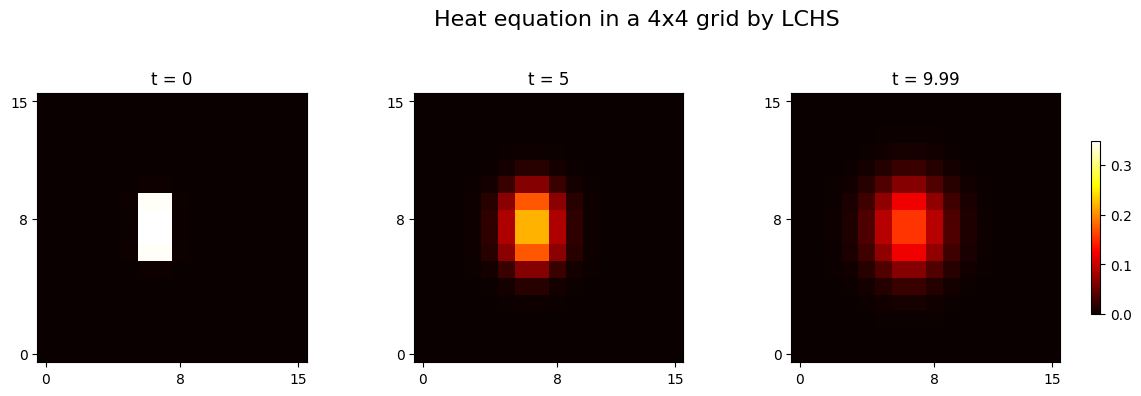

In [88]:
idx = [0, 5, 9.99]
n, nx, ny, dt = 8, 4, 4, 0.1

# make a copy of the data
w = w_q_series.copy()

# 1) build all 2D snapshots in order
zs = [
    w[int(t/dt), :2**n].real.reshape(2**ny, 2**nx)
    for t in idx
]

# 2) find global min/max
vmin = min(z.min() for z in zs)
vmax = max(z.max() for z in zs)

# 3) prep norm + colormap
cmap = 'hot'
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 4) make subplots
fig, axes = plt.subplots(1, len(idx), figsize=(16, 4.5))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# 5) plot each panel in sequence
for ax, z, t in zip(axes, zs, idx):
    im = ax.imshow(z, origin='lower', cmap=cmap, norm=norm)
    ax.set_aspect('equal')
    ax.set_xticks(list(range(0, 2**nx, 8)) + [2**nx-1])
    ax.set_yticks(list(range(0, 2**ny, 8)) + [2**ny-1])
    ax.set_title(f't = {t}')

# optional: print the maxima
print([z.max() for z in zs])

# 6) add the colorbar (pad bumped to avoid overlap)
fig.colorbar(im, ax=axes, pad=0.025, shrink=0.5)

# 7) super‐title + spacing just like before
fig.suptitle('Heat equation in a 4x4 grid by LCHS',
             fontsize=16)

plt.show()

Finally, let us try to use UnitarySimulator to see the effect of the LCHS! As we will see, due to the combination of a large number of $k_a$ and the Trotterization error, the result is not ideal which actually reflects the necessity of the MPS approximation!

In [76]:
# Simulation parameters
T = 10.0
dt = 0.1
sample_rate = 1

# boundary conditions
bc_dict = {
    '0': ('D', 'D'),
    '1': ('D', 'D')
}

c_list = [2**(-n_frac) / (np.pi * (1 + k**2)) for k in k_list]
L = heat_hamiltonian(nx, ny, h, bc_dict, kappa)

# Initial state in matrix form
w_q = np.zeros((2**nx, 2**ny))
w_q[2**(ny-1)-2:2**(ny-1)+2, 2**(nx-1)-2:2**(nx-1)] = 1
w_q = w_q.flatten()
w_q = w_q / np.linalg.norm(w_q)


w_init = w_q.copy()
w_branches = []

for k, c in zip(k_list, c_list):
    lchs = LCHSimulation(k*L)
    lchs.simulation_circuit(dt=dt)
    w_q_list = lchs.matrix_simulation_evolve(T=T, state=w_init, sample_rate=sample_rate)
    w_branches.append(c * w_q_list)

# Sum over k_a branches to get the overall evolution
w_branches = np.array(w_branches)          # shape (len(k_list), n_steps, dim)
w_q_series = np.sum(w_branches, axis=0)    # shape (n_steps, dim)

# w_q_series[j] is the unnormalised state at time t=j*dt

[np.float64(0.3500392463187873), np.float64(0.13850231126448198), np.float64(0.07963790871148296)]


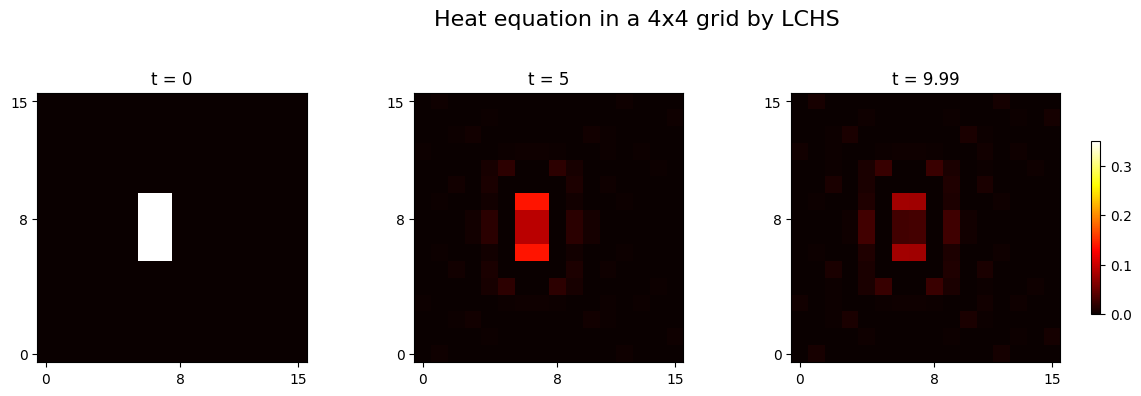

In [80]:
idx = [0, 5, 9.99]
n, nx, ny, dt = 8, 4, 4, 0.1

# make a copy of the data
w = w_q_series.copy()

# 1) build all 2D snapshots in order
zs = [
    w[int(t/dt), :2**n].real.reshape(2**ny, 2**nx)
    for t in idx
]

# 2) find global min/max
#vmin = min(z.min() for z in zs)
#vmax = max(z.max() for z in zs)

# 3) prep norm + colormap
cmap = 'hot'
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 4) make subplots
fig, axes = plt.subplots(1, len(idx), figsize=(16, 4.5))
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# 5) plot each panel in sequence
for ax, z, t in zip(axes, zs, idx):
    im = ax.imshow(z, origin='lower', cmap=cmap, norm=norm)
    ax.set_aspect('equal')
    ax.set_xticks(list(range(0, 2**nx, 8)) + [2**nx-1])
    ax.set_yticks(list(range(0, 2**ny, 8)) + [2**ny-1])
    ax.set_title(f't = {t}')

# optional: print the maxima
print([z.max() for z in zs])

# 6) add the colorbar (pad bumped to avoid overlap)
fig.colorbar(im, ax=axes, pad=0.025, shrink=0.5)

# 7) super‐title + spacing just like before
fig.suptitle('Heat equation in a 4x4 grid by LCHS',
             fontsize=16)

plt.show()